In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from Ge_calculation import GAP, MD_run
from Ge_analysis import *
import pickle
from ase.io.cfg import read_cfg
import numpy as np
import os
from ase import build
from ase.atoms import Atoms
from quippy.potential import Potential
from quippy.descriptors import Descriptor
from ase.io.proteindatabank import read_proteindatabank, write_proteindatabank
from ase.io import read
from copy import deepcopy
from ase.io.castep import read_castep_castep, read_param
from ase.io import read
from ase.io.extxyz import read_xyz, write_xyz
from ase.data import atomic_masses
from ase.neighborlist import neighbor_list
from ase.data import covalent_radii
import pandas as pd
from ase.lattice import hexagonal, tetragonal, orthorhombic
from ase.constraints import StrainFilter, UnitCellFilter, ExpCellFilter, FixAtoms
from ase.optimize import BFGS
import pymatgen.ext.matproj as mp
import pymatgen.core.periodic_table as pt
import pymatgen.io.ase as pase
from sklearn import decomposition
from pyuoi.decomposition import CUR
import matplotlib.pyplot as plt

/home/joe/miniconda3/envs/Q/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/joe/miniconda3/envs/Q/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.coordinate_descent module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/joe/miniconda3/envs/Q/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.lin

In [5]:
GE = '/home/joe/Documents/Ge_od/'

In [30]:
# Databases and potentials for our GAP-MD driven homegrown DB and one from the literature
# latter includes only structures labelled amorphous or liquid
my = GAP(GE+'Potentials/Si_myDB_216/train_64_125_216_full.xyz',
         val_file=None,
         pot=GE+'Potentials/Si_myDB_216/Si_myDB_64_125_216_full.xml')

lit_al = GAP(GE+'Potentials/Si_litDB_amoliq/gp_iter6_liqamo.xyz',
             val_file=None,
             pot=GE+'Potentials/Si_litDB_amoliq/Si_litDB_liqamo.xml',
             parameter_names=('dft_energy', 'dft_force', 'dft_virial'))

lit_al_lp = GAP(GE+'Potentials/Si_litDB_amoliq/gp_iter6_liqamo_lp.xyz',
                val_file=None,
                pot=GE+'Potentials/Si_litDB_amoliq/Si_litDB_liqamo_lp.xml',
                parameter_names=('dft_energy', 'dft_force', 'dft_virial'))

Training set structure count: 351
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['amorph', 'inter', 'hiT_amorph', 'liq', 'hiT_liq']
Training set structure count: 236
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['liq', 'amorph']
Training set structure count: 213
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['liq', 'amorph']


In [13]:
litDB_full = list(read_xyz(GE+'Structure_databases/gp_iter6_sparse9k.xml.xyz', index=slice(0,None)))

In [78]:
myDB = list(read_xyz(GE+'Potentials/Si_myDB_216/train_64_125_216_full.xyz', index=slice(0,None)))

## Compare database compositions
make sure to use $$ d = \sqrt{2 - 2\bar{K}(\mathbf{i},\mathbf{j})} $$ for similarity maps

In [82]:
t = my.T_configs
my_2 = [t[0] + t[2], t[1] + t[3] + t[4]]

In [99]:
sum(lmy_s[1])



19830

Mean size of DB entries / natoms:
lit    : 148.70
my     : 94.43
Distribution:
lit    : [100.   0.   0.   0.  20.   0.   0.   0.   0.  20.]
my     : [250.   0.   0.   0.  50.   0.   0.   0.   0.  50.]
       [ 64.   79.2  94.4 109.6 124.8 140.  155.2 170.4 185.6 200.8 216. ]


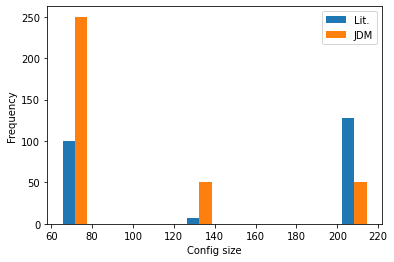

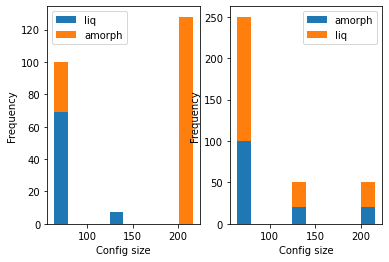

In [84]:
print('Mean size of DB entries / natoms:\nlit    : {0:3.2f}\nmy     : {1:3.2f}'.format(
        np.average(llit := [len(i) for i in flatten(lit_al.T_configs)]),
        np.average(lmy := [len(i) for i in flatten(my.T_configs)])))

llit_s = [[len(i) for i in j] for j in lit_al.T_configs]
#lmy_s = [[len(i) for i in j] for j in my.T_configs]
lmy_s = [[len(i) for i in j] for j in my_2]
fig, axs = plt.subplots(1)
dist, bins = axs.hist([llit,lmy], label=['Lit.', 'JDM'])[0:2]
axs.legend()
axs.set(xlabel='Config size', ylabel='Frequency')

fig2, axs2 = plt.subplots(1,2)
for i in axs2:
    i.set(xlabel='Config size', ylabel='Frequency')
dist, bins = axs2[0].hist(llit_s, label=lit_al.config_labels, stacked=True)[0:2]
dist, bins = axs2[1].hist(lmy_s, label=['amorph', 'liq'], stacked=True)[0:2]
axs2[0].legend(); axs2[1].legend()

print('Distribution:\nlit    : {0}\nmy     : {1}\n       {2}'.format(
    dist[0], dist[1], bins
))

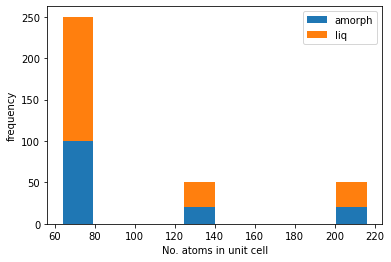

In [93]:
fig, axs = plt.subplots()
dist, bins = axs.hist(lmy_s, label=['amorph', 'liq'], stacked=True)[0:2]
axs.legend()
axs.set(xlabel='No. atoms in unit cell', ylabel='frequency')
fig.savefig('/home/joe/OneDrive/slack_figures/my_hist.png')

Idea: restrict the literature DB so it matches the current size
and distribution of mine and see if failure results *pending lammps run*

In [5]:
def red_DB_cfg(xyz, ctypes = [None], size_dist=None, outfile=None):
    '''Reduces a database's configuration count for robustness stress-testing
    ctypes: list of str, config_types to keep in new DB. Leave None for all
    size_dist: dict, sizes and their desired relative fractions
    outfile: str, optional custom name for new DB file'''
    size_dist.update({1:1})
    ats = read_xyz(xyz, index=slice(0,None))
    keeps = []
    ct = 0; ct_kept = 0; popped = []
    for i, val in enumerate(ats):
        if (val.info['config_type'] in ctypes or 'isol' in val.info['config_type'] or None in ctypes) \
            and np.random.rand() < size_dist[len(val)]:
            keeps.append(val)
            ct_kept += 1
        else:
            ct += 1
            if val.info['config_type'] not in popped:
                popped.append(val.info['config_type'])

    if outfile is None:
        outfile = xyz.split('.')[:-1] + '_red.xyz'

    write_xyz(outfile, keeps)

    print('total {0} popped\n\nconfig_types removed: {1}'.format(ct, popped))

    return keeps

In [ ]:
os.chdir(GE+'Potentials/Si_litDB_amoliq')
keeps = red_DB_cfg(GE+'Potentials/Si_litDB_amoliq/gp_iter6_liqamo.xyz',
                   size_dist={64:1, 128:1, 216:(50/128)}, outfile='gp_iter6_liqamo_216match.xyz')

In [ ]:
k = GAP(GE+'Potentials/Si_litDB_amoliq/gp_iter6_liqamo_216match.xyz',
             parameter_names=('dft_energy', 'dft_force', 'dft_virial'))
lk_s = [[len(i) for i in j] for j in k.T_configs]
fig, axs = plt.subplots()
dist, bins = axs.hist(lk_s, label=k.config_labels, stacked=True)[0:2]
axs.legend()

In [ ]:
print(sum(flatten(lk_s)), sum(lmy))

gap_fit run on the above (with the number of 216-atom lit structures heavily restricted)


Measure some sort of correlation function among amorphous structures in the lit DB:
* SOAP similarities between them
* Standard deviation instead of averaged kernels? Potentially expensive


In [8]:
def kernel_mat(cfgs,
                desc=Descriptor('soap average=T l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'),
                zeta=4):
    '''calculates the average/std dev similarity kernel among a set of
    configs.
    should do it more efficiently using symmetry einsum
    '''
    descs = np.array(flatten(desc.calc_descriptor(cfgs)))
    descs = descs.reshape(-1, descs.shape[-1]) # flatten out all the environs
    print(descs.shape)
    k = np.sqrt(2 - 2*np.array(np.einsum('ij,kj', descs, descs)**zeta))
    np.nan_to_num(k, copy=False)
    pca = decomposition.PCA(n_components=2)
    pca.fit(k)
    red = pca.fit_transform(k)

    return k, red

In [32]:
lit_k, lit_red = kernel_mat(lit_al.T_configs)

(235, 547)


<ipython-input-31-00e03f85d8ed>:13: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt(2 - 2*np.array(np.einsum('ij,kj', descs, descs)**zeta))


In [33]:
my_k, my_red = kernel_mat(my.T_configs)

(350, 547)


<ipython-input-31-00e03f85d8ed>:13: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt(2 - 2*np.array(np.einsum('ij,kj', descs, descs)**zeta))


In [34]:
comb_k, comb_red = kernel_mat(flatten(lit_al.T_configs + my.T_configs))
comb_k_lp, comb_red_lp = kernel_mat(flatten(lit_al_lp.T_configs + my.T_configs))

(585, 547)
(562, 547)


<ipython-input-31-00e03f85d8ed>:13: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt(2 - 2*np.array(np.einsum('ij,kj', descs, descs)**zeta))
<ipython-input-31-00e03f85d8ed>:13: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt(2 - 2*np.array(np.einsum('ij,kj', descs, descs)**zeta))


In [15]:
litfull_my_k, litfull_my_red = kernel_mat(litDB_full + myDB)

(2826, 547)


<ipython-input-8-00e03f85d8ed>:13: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt(2 - 2*np.array(np.einsum('ij,kj', descs, descs)**zeta))


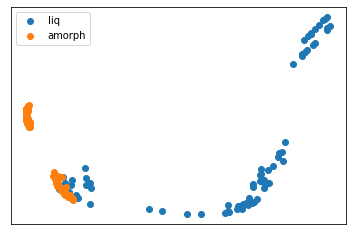

In [11]:
fig, axs = plt.subplots()
red_s = [np.array([lit_red[i] for i in range(len(flatten(lit_al.T_configs[:ct])),
                                         len(flatten(lit_al.T_configs[:ct])) + len(j))])
         for ct, j in enumerate(lit_al.T_configs)]
for i, val in enumerate(red_s):
    axs.scatter(val.T[0], val.T[1], label=lit_al.config_labels[i])
# for i, val in enumerate(red.T[0]):
#     if (x := flatten(lit_al.data_dict['T_configs'])[i].info['dft_virial']) is not None:
#         if 0.333*np.trace(x.reshape([3,3])) > 10:
#             axs.scatter(red.T[0][235+i], red.T[1][235+i], color='Orange', marker='s')
axs.get_xaxis().set(visible=False)
axs.get_yaxis().set(visible=False)
axs.legend()

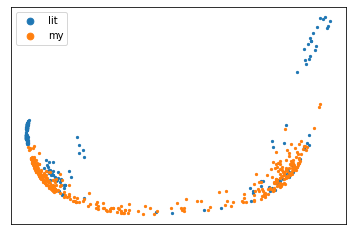

In [12]:
fig, axs = plt.subplots()
# comb_red_s = [np.array([i for i in comb_red[slices[j]:slices[j+1]]]) for j in range(len(slices)-1)]
comb_red_s = [np.array([i for i in comb_red[:len(flatten(lit_al.T_configs))]]),
              np.array([i for i in comb_red[len(flatten(lit_al.T_configs)):]])]
# labels = ['lit_' + i for i in lit_al.config_labels] + ['my_' + i for i in my.config_labels]
labels = ['lit', 'my']
for i, val in enumerate(comb_red_s):
    axs.scatter(val.T[0], val.T[1], label=labels[i], s=5)
axs.get_xaxis().set(visible=False)
axs.get_yaxis().set(visible=False)
axs.legend(markerscale=3)

In [36]:
arrs = [lit_al.T_configs, my.T_configs]
slices = [0] + [len(j) for i in arrs for j in i] + [None]
slices = [sum(slices[:j+1]) for j in range(len(slices)-1)]
slices

[0, 76, 235, 305, 375, 445, 515, 585]

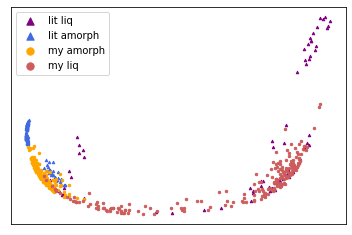

In [41]:
fig, axs = plt.subplots()
comb_red_s = [np.array([i for i in comb_red[slices[j]:slices[j+1]]]) for j in range(len(slices)-1)]
t = comb_red_s
axs.scatter(*t[0].T, label='lit liq', s=6, marker='^', color='Purple')
axs.scatter(*t[1].T, label='lit amorph', s=6, marker='^', color='RoyalBlue')
axs.scatter(*np.concatenate([t[2],t[4]]).T, label='my amorph', s=6, color='Orange')
axs.scatter(*np.concatenate([t[3],t[5],t[6]]).T, label='my liq', s=6, color='IndianRed')
axs.get_xaxis().set(visible=False)
axs.get_yaxis().set(visible=False)
axs.legend(markerscale=3)
fig.savefig('/home/joe/OneDrive/slack_figures/smap_litmy.png', bbox_inches='tight', dpi=100)

In [88]:
for i in myDB:
    if 'amorph' or 'inter' in i.info['config_type']:
        i.info['config_type'] = 'my amorph'
    else:
        i.info['config_type'] = 'my liq'
DB = litDB_full + myDB
col, inv = np.unique([i.info['config_type'] for i in DB], return_inverse=True)
sizes = 4*np.ones(len(inv))
sizes[inv==1] *= 2
sizes[inv==15] *= 2
sizes[inv==16] *= 2

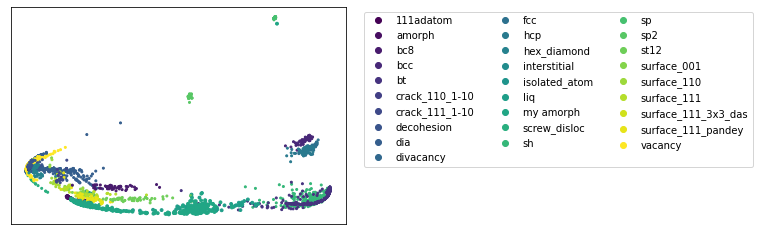

In [90]:
fig, axs = plt.subplots()
scatter = axs.scatter(*litfull_my_red.T, c=inv, s=sizes, cmap='viridis')
axs.get_xaxis().set(visible=False)
axs.get_yaxis().set(visible=False)
handles, labels = scatter.legend_elements(num=28)
axs.legend(handles, col, markerscale=1.0, loc='upper left', bbox_to_anchor=(1.04, 1.0), ncol=3)
fig.savefig('/home/joe/OneDrive/slack_figures/smap_litfull_myDB.png', bbox_inches='tight', dpi=100)

In [81]:
labels

col

array(['111adatom', 'amorph', 'bc8', 'bcc', 'bt', 'crack_110_1-10',
       'crack_111_1-10', 'decohesion', 'dia', 'divacancy', 'fcc', 'hcp',
       'hex_diamond', 'interstitial', 'isolated_atom', 'liq', 'my amorph',
       'screw_disloc', 'sh', 'sp', 'sp2', 'st12', 'surface_001',
       'surface_110', 'surface_111', 'surface_111_3x3_das',
       'surface_111_pandey', 'vacancy'], dtype='<U19')

Some sort of general scheme for labelling these structure maps with auxiliary
properties, e.g.
* Density
* C.N.

In [ ]:
def group_red(red, map):
    return

In [42]:
red_f_lab = []
for i, val in enumerate(flatten(lit_al.T_configs)):
    red_f_lab.append(np.average(np.linalg.norm(val.get_array('dft_force'), axis=1)))
for i, val in enumerate(flatten(my.T_configs)):
    red_f_lab.append(np.average(np.linalg.norm(val.get_array('dft_forces'), axis=1)))

In [43]:
red_e_lab = []
for i, val in enumerate(flatten(lit_al.T_configs)):
    red_e_lab.append((val.info['dft_energy']/len(val) - (lit_al.zero_e - my.zero_e)))
for i, val in enumerate(flatten(my.T_configs)):
    red_e_lab.append(val.info['dft_energy']/len(val))

In [44]:
red_d_lab = []
for i, val in enumerate(flatten(lit_al.T_configs + my.T_configs)):
    red_d_lab.append(atomic_masses[14]*len(val)/(val.get_volume()*10.0e-24*6.02e23))

In [45]:
def cn_count(at):
    r = covalent_radii[at.get_atomic_numbers()[0]]*2.5
    i = neighbor_list('i', at, r)
    coord = np.bincount(i)
    stat = np.bincount(coord)

    return stat

red_cn_lab = []; red_lp_cn_lab = []
for i, val in enumerate(flatten(lit_al.T_configs + my.T_configs)):
    red_cn_lab.append(cn_count(val))
for i, val in enumerate(flatten(lit_al_lp.T_configs + my.T_configs)):
    red_lp_cn_lab.append(cn_count(val))

l = max([len(i) for i in red_cn_lab])
l_lp = max([len(i) for i in red_lp_cn_lab])
red_cn_lab = np.asarray([np.pad(a, (0, l - len(a)), 'constant', constant_values=0) for a in red_cn_lab])
red_lp_cn_lab = np.asarray([np.pad(a, (0, l_lp - len(a)), 'constant', constant_values=0) for a in red_lp_cn_lab])
red_cn4_lab = red_cn_lab[:, 4]/np.sum(red_cn_lab, axis=1)
red_cnmode_lab = np.argmax(red_cn_lab, axis=1)
red_lp_cnmode_lab = np.argmax(red_lp_cn_lab, axis=1)

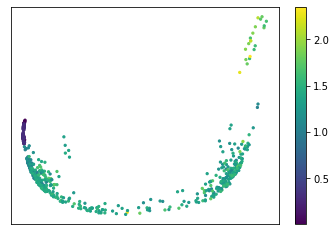

In [19]:
fig, axs = plt.subplots()
cax = axs.scatter(comb_red.T[0], comb_red.T[1], c=red_f_lab, cmap='viridis', s=5)
axs.get_xaxis().set(visible=False)
axs.get_yaxis().set(visible=False)
cbar = fig.colorbar(cax)

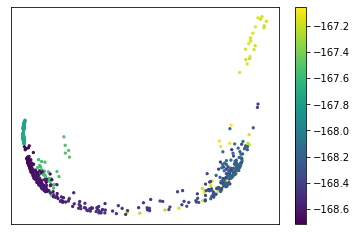

In [20]:
fig, axs = plt.subplots()
cax = axs.scatter(comb_red.T[0], comb_red.T[1], c=red_e_lab, cmap='viridis', s=5)
axs.get_xaxis().set(visible=False)
axs.get_yaxis().set(visible=False)
cbar = fig.colorbar(cax)

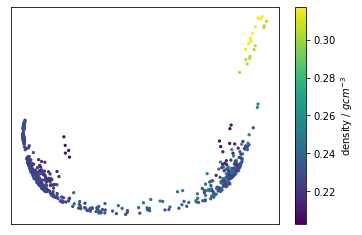

In [48]:
fig, axs = plt.subplots()
cax = axs.scatter(comb_red.T[0], comb_red.T[1], c=red_d_lab, cmap='viridis', s=5)
axs.get_xaxis().set(visible=False)
axs.get_yaxis().set(visible=False)
cbar = fig.colorbar(cax, label='density / $gcm^{-3}$')
fig.savefig('/home/joe/OneDrive/slack_figures/smap_density.png', dpi=100, bbox_inches='tight')

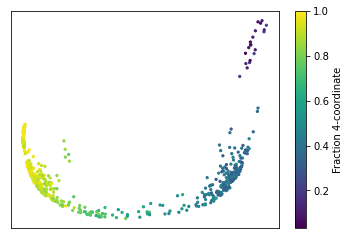

In [89]:
fig, axs = plt.subplots()
cax = axs.scatter(comb_red.T[0], comb_red.T[1], c=red_cn4_lab, cmap='viridis', s=5)
axs.get_xaxis().set(visible=False)
axs.get_yaxis().set(visible=False)
cbar = fig.colorbar(cax, label='Fraction 4-coordinate')

In [50]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))
norm = MidpointNormalize(vmin=red_cnmode_lab.min(), vmax=red_cnmode_lab.max(), midpoint=4)

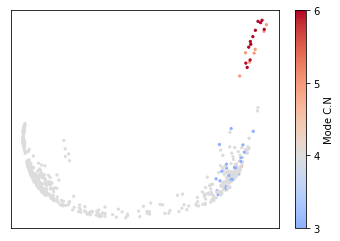

In [51]:
fig, axs = plt.subplots()
cax = axs.scatter(comb_red.T[0], comb_red.T[1], c=red_cnmode_lab, cmap='coolwarm', norm=norm, s=5)
axs.get_xaxis().set(visible=False)
axs.get_yaxis().set(visible=False)
cbar = fig.colorbar(cax, label='Mode C.N', ticks=mpl.ticker.IndexLocator(base=1, offset=0))
fig.savefig('/home/joe/OneDrive/slack_figures/smap_mode_CN.png', dpi=100, bbox_inches='tight')

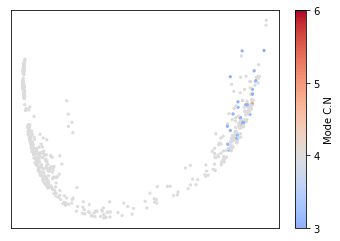

In [25]:
fig, axs = plt.subplots()
cax = axs.scatter(comb_red_lp.T[0], comb_red_lp.T[1], c=red_lp_cnmode_lab, cmap='coolwarm', norm=norm, s=5)
axs.get_xaxis().set(visible=False)
axs.get_yaxis().set(visible=False)
cbar = fig.colorbar(cax, label='Mode C.N', ticks=mpl.ticker.IndexLocator(base=1, offset=0))

From the density plot, *my* is missing the compressed liquid data. Now checking to see if *lit* suffers
from their omission - *update: it doesn't (still >90% 4-coordinate)*

In [106]:
ats = flatten(lit_al.T_configs)
outfile = 'Si_litDB_liqamo_lp.xyz'
keeps = []
ct = 0; ct_kept = 0; popped = []
for i, val in enumerate(ats):
    if red_cnmode_lab[i] <= 4:
        keeps.append(val)
        ct_kept += 1
    else:
        ct += 1
        if val.info['config_type'] not in popped:
            popped.append(val.info['config_type'])

if outfile is None:
    outfile = xyz.split('.')[:-1] + '_red.xyz'

write_xyz(outfile, keeps)

print('total {0} popped\n\nconfig_types removed: {1}'.format(ct, popped))

total 22 popped

config_types removed: ['liq']


In [147]:
bins = np.array(range(red_cn_lab.shape[1]))
ones = np.ones(red_cn_lab.shape)
mean = np.average(bin_mat := np.multiply(bins, ones), weights=red_cn_lab, axis=1)

In [153]:
var = np.average(((bin_mat.T - mean)**2).T, weights=red_cn_lab, axis=1)

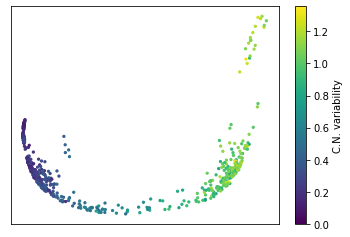

In [155]:
fig, axs = plt.subplots()
cax = axs.scatter(comb_red.T[0], comb_red.T[1], c=np.sqrt(var), cmap='viridis', s=5)
axs.get_xaxis().set(visible=False)
axs.get_yaxis().set(visible=False)
cbar = fig.colorbar(cax, label='C.N. variability')



SOAP variability would be cool

Idea: evaluate the variance of the descriptor for each environment

In [ ]:
def kernel_var(cfgs,
                desc=Descriptor('soap average=F l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'),
                zeta=4):
    '''calculates the std dev similarity kernel among a set of
    configs.
    Need to worry about size differences between structures
    '''
    var_k = []
    for i in cfgs:
        d = desc.calc_descriptor(i)
        var_k.append([])
        for j in cfgs:
            t = desc.calc_descriptor(j)
            k =

    descs = np.array(flatten(desc.calc_descriptor(cfgs)))
    descs = descs.reshape(-1, descs.shape[-1]) # flatten out all the environs
    print(descs.shape)
    k = np.sqrt(2 - 2*np.array(np.einsum('ij,kj', descs, descs)**zeta))
    np.nan_to_num(k, copy=False)
    pca = decomposition.PCA(n_components=2)
    pca.fit(k)
    red = pca.fit_transform(k)

    return k, red

With similar database sizes and composition, it seems diversity is not the problem leading to collapse of the MD.
Perhaps the issue is with either the DFT (insufficient convergence) or the hypers (too tight -> overfitting)
or the distance of the MD runs from the DFT minima. Comparing DFT force magnitudes should reveal if the latter is the case

Fitting an MTP to the same data, this will tell us if the problem is with GAP or with the dataset. Will be
interesting to see what the MTP does in this situation (may be cheap enough to try one of these global opts, should
compare the lammps stats between different methodologies trained on the same DB). *mtp also gets majority 4-coord
straight off*. Should run a 1000-atom simulation for assessing $S(Q)$

Concurrently fitting a very loose GAP (factor of 5 looser) to see if this makes a difference.
LOOSE WORKED! Get a Td system on quenching. V exciting. Should try this immediately with the Ge system to see
if this carries over (answer: it doesn't). Understanding why this is the case will form an important analysis in the
paper (of general interest). The fact that databases that are all but indistinguishable in terms of broad size, composition,
structural diversity perform so differntly

a.) because the DFT data is poorly converged (e.g. w.r.t. kpoints or cutoff)
b.) the GAP-driven MD is somewhat far from a DFT trajectory. In order to describe well the DFT minima,
it is therefore of paramount importance not to overfit (otherwise end up in false minima---collapse)

Compare force evaluations on lit DB by lit and my GAPs (appear to have comparable spreads and means)

Do a force-dependent regularisation to optimise (and/or a config-dependent one - looser on the liquid or amorph? try both)

Type something out to VLD when you get the chance (and MTP/analysis is finished)
General outline:
* Adding all the Si DFT still failed

* Restricting the lit DB to the same size and composition remained successful -> implies that the problem is on the local
environment level (would be v useful to devise a way to measure this).

My hunch: GAP trajectory too distant from DFT one/minima to furnish an accurate potential --> overfitting particularly
obvious in this case (false minima located).

* Confirmed by a much looser-regularisation fit giving a majority 4-coordinate amorphous structure for my Si data,
as does a moment tensor potential trained on the

* However the rescaled Ge data does not yet give a good amorphous structures, even with a very loose fit (and also for
mtp potential).

* Do MTPs follow this behaviour as well? i.e. is the distance from DFT a problem for GAPs in particular (they are fragile
or our setup is sub-optimal) or one of ML potentials in general (that the data is just not good enough). The fact that
the alternative reading of the GAP with those problems we were having earlier on suggests to me that it is the former
that's the problem and that eiter our hypers are wrong or GAPs are fragile in these situations. Yet the Ge results refute
that. Interesting point: mtp seemed quite unstable at 1000 atoms (required rescaling and new random cell with no short
contacts, built with AIRSS)

* currently fitting even looser GAP and an MTP to the Ge data to see - neither worked

* perhaps could fit a potential to GAP energy and forces?

Possible conclusions here

Figures to include



In [ ]:
lit_forces = np.array([])
my_forces = np.array([])
for i, val in enumerate(lit_al_lp.T_configs[0]):
    lit_forces = np.concatenate((lit_forces, (np.ravel(np.linalg.norm(val.get_array('dft_force'), axis=1)))))
for i, val in enumerate(flatten(my.T_configs[3:4])):
    my_forces = np.concatenate((my_forces, (np.ravel(np.linalg.norm(val.get_array('dft_forces'), axis=1)))))

In [ ]:
fig, axs = plt.subplots(1, figsize=(2,6))
axs.boxplot((lit_forces, my_forces), whis=[5,95], widths=0.3, flierprops={'marker':'x', 'markersize':2})

In [ ]:
lit_al.calc(val=False)

In [ ]:
my.calc(val=False)

In [ ]:
lit_al.save(GE+'Potentials/Si_litDB_amoliq/gp_iter6_liqamo.xyz.pickle')
my.save(GE+'Potentials/Si_myDB_216/train_64_125_216_full.xyz.pickle')

In [35]:
rnd1000 = read('/home/joe/scripts/lammps/rnd1000.out', format='castep-cell')
rnd64 = read('/home/joe/scripts/lammps/rnd_64001.data', format='lammps-data', style='atomic')
rnd1000.set_cell(rnd1000.cell*1.15, scale_atoms=True)
from ase.neighborlist import neighbor_list
from ase.io.lammpsdata import write_lammps_data
from ase.md import langevin
from ase.build import bulk
l = neighbor_list('d', rnd1000, 2.7)
l.min()
write_lammps_data('rnd_1000.data', rnd1000)
rnd1000.cell

/home/joe/ase/ase/calculators/castep.py:3065: UserWarning: Generating CASTEP keywords JSON file... hang on.
    The CASTEP keywords JSON file contains abstractions for CASTEP input
    parameters (for both .cell and .param input files), including some
    format checks and descriptions. The latter are extracted from the
    internal online help facility of a CASTEP binary, thus allowing to
    easily keep the calculator synchronized with (different versions of)
    the CASTEP code. Consequently, avoiding licensing issues (CASTEP is
    distributed commercially by accelrys), we consider it wise not to
    provide the file in the first place.
  warnings.warn("""Generating CASTEP keywords JSON file... hang on.
/home/joe/ase/ase/calculators/castep.py:477: UserWarning: Could not determine the version of your CASTEP binary 
This usually means one of the following 
   * you do not have CASTEP installed 
   * you have not set the CASTEP_COMMAND to call it 
   * you have provided a wrong CASTEP

In [44]:

import numpy as np

from scipy.stats import gaussian_kde

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from ase.io import read, write
from ase.neighborlist import neighbor_list

from collections import Counter

from quippy.descriptors import Descriptor

from matscipy.rings import ring_statistics

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [ 'Helvetica', 'Arial', 'FreeSans', 'DejaVu Sans' ]

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['legend.borderaxespad'] = 1.5

plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.5

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.0

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.0

In [18]:
lSi_exp_Sq = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/Si_Sq_exp_Waseda1974.txt',
                          delimiter=', ').T
lSi_exp_Sq[1] += -0.5

aSi_exp_Sq = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/a-Si_x-ray_Laaziri1999.txt',
                          delimiter=', ').T

In [20]:
Si_mlp1000_MD = MD_run(GE+'MD_runs/mlip/my/run_1000_Si_myDB_liqamo_216_full')
Si_loomy_GAP1000_MD = MD_run(GE+'MD_runs/Si_my_DB_216/run_1000_001')

In [56]:
Si_litDB_full = MD_run('/home/joe/Documents/Ge_od/MD_runs/Si_litDB_full_4000/run_1000_001')

In [24]:
Si_mlp1000_MD.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir=GE+'MD_runs/mlip/my/run_1000_Si_myDB_liqamo_216_full/Sq_rings/',
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True,
                    rings_command='/home/joe/rings-code-v1.3.4/src/rings')
Si_mlp1000_MD.bin_fit(s_selection=[i for i in range(90)], q_selection=[0.5,12])
Si_mlp1000_MD.bin_fit(s_selection=[i for i in range(90, 110)], q_selection=[0.5,12])

In [22]:
Si_loomy_GAP1000_MD.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir=GE+'MD_runs/Si_my_DB_216/run_1000_001/Sq_rings/',
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=False,
                    rings_command='/home/joe/rings-code-v1.3.4/src/rings')
Si_loomy_GAP1000_MD.bin_fit(s_selection=[i for i in range(90)], q_selection=[0.5,12])
Si_loomy_GAP1000_MD.bin_fit(s_selection=[i for i in range(90, 110)], q_selection=[0.5,12])

R.I.N.G.S ran successfully


In [58]:
Si_litDB_full.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='/home/joe/Documents/Ge_od/MD_runs/Si_litDB_full_4000/Sq_rings_1000_001/',
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=False,
                    rings_command='/home/joe/rings-code-v1.3.4/src/rings')
Si_litDB_full.bin_fit(s_selection=[i for i in range(90)], q_selection=[0.5,12])
Si_litDB_full.bin_fit(s_selection=[i for i in range(90, 110)], q_selection=[0.5,12])

R.I.N.G.S ran successfully


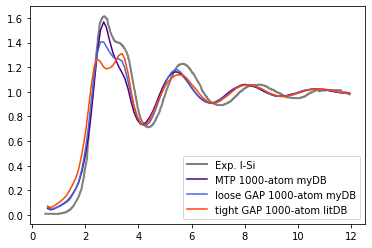

In [61]:
fig, axs = plt.subplots()
axs.errorbar(*Si_mlp1000_MD.Sq_x_av[0], yerr=None,
            label=r'MTP 1000-atom myDB', color='Indigo')
axs.errorbar(*Si_loomy_GAP1000_MD.Sq_x_av[0], yerr=None,
            label=r'loose GAP 1000-atom myDB', color='RoyalBlue')
axs.errorbar(*Si_litDB_full.Sq_x_av[0], yerr=None,
            label=r'tight GAP 1000-atom litDB', color='orangered')
axs.plot(*lSi_exp_Sq, color='Gray', linewidth=2, label='Exp. l-Si')
axs.legend()
fig.savefig('/home/joe/slack_figures/lSi_mtp_lGAP.png', bbox_inches='tight', dpi=100)

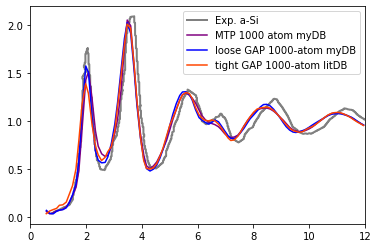

In [62]:
fig, axs = plt.subplots()
axs.errorbar(*Si_mlp1000_MD.Sq_x_av[1], yerr=None,
            label=r'MTP 1000 atom myDB', color='Purple')
axs.errorbar(*Si_loomy_GAP1000_MD.Sq_x_av[1], yerr=None,
            label=r'loose GAP 1000-atom myDB', color='Blue')
axs.errorbar(*Si_litDB_full.Sq_x_av[1], yerr=None,
            label=r'tight GAP 1000-atom litDB', color='orangered')
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=2, label='Exp. a-Si')
axs.legend()
axs.set(xlim=(0,12))
fig.savefig('/home/joe/slack_figures/aSi_mtp_lGAP.png', bbox_inches='tight', dpi=100)

In [63]:
my_loose = GAP('/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/train_64_125_216_full.xyz',
               pot='/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/Si_myDB_liqamo_loose.xml')


Training set structure count: 351
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['amorph', 'inter', 'hiT_amorph', 'liq', 'hiT_liq']


In [64]:
my_loose.calc(val=False)


Config amorph done
Config inter done
Config hiT_amorph done
Config liq done
Config hiT_liq done
--- 195.65711975097656 seconds ---


In [65]:
my_tight = GAP(GE+'Potentials/Si_myDB_216/train_64_125_216_full.xyz',
         val_file=None,
         pot=GE+'Potentials/Si_myDB_216/Si_myDB_64_125_216_full.xml')
my_tight.calc(val=False)

Training set structure count: 351
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['amorph', 'inter', 'hiT_amorph', 'liq', 'hiT_liq']
Config amorph done
Config inter done
Config hiT_amorph done
Config liq done
Config hiT_liq done
--- 158.3560826778412 seconds ---


KeyError: 'GAP_F_t'

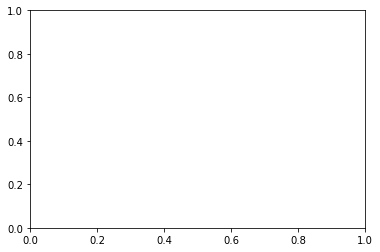

In [67]:
forces_error(my_loose, by_config=False)


In [68]:
my_loose.analyse()


ValueError: operands could not be broadcast together with shapes (70,9) (70,3,3) 

In [69]:
len(flatten(my_loose.T_configs))


350

In [ ]:
def kernel_mat(cfgs,
                desc=Descriptor('soap average=T l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'),
                zeta=4):
    '''calculates the average/std dev similarity kernel among a set of
    configs.
    should do it more efficiently using symmetry einsum
    '''
    descs = desc.calc_descriptor(cfgs)
    descs = descs.reshape(-1, descs.shape[-1]) # flatten out all the environs
    print(descs.shape)
    k = np.sqrt(2 - 2*np.array(np.einsum('ij,kj', descs, descs)**zeta))
    np.nan_to_num(k, copy=False)
    pca = decomposition.PCA(n_components=2)
    pca.fit(k)
    red = pca.fit_transform(k)

    return k, red

In [ ]:
myDB =
litDB =